In [1]:
import nengo
import nengo.spa as spa

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from utils import gen_feed_func, gen_vecs_jan, gen_vecs_aaron

import itertools

In [2]:
n_items = 4
t_present = 0.05
D = 16
dt = 0.001
similarity = 0.9

In [13]:
vocab = spa.Vocabulary(D)

targ_class = []

stim_vecs = gen_vecs_jan(n_items, D, similarity)
stim_lbl = []

for v_i, vec in enumerate(stim_vecs):
    lbl = "S%d" % v_i
    stim_lbl.append(lbl)
    vocab.add(lbl, vec)

    targ = np.zeros(n_items)
    targ[v_i] = 1
    targ_class.append(targ)

print(stim_lbl)

for s1, s2 in itertools.combinations(stim_lbl, 2):
    print(np.dot(vocab.parse(s1).v, vocab.parse(s2).v))

['S0', 'S1', 'S2', 'S3']
0.9
0.9
0.9
0.9
0.9
0.9


# Baseline

In [14]:
with nengo.Network() as model:
    in_nd = nengo.Node(gen_feed_func(vocab, stim_lbl, t_present))

    recog = nengo.Ensemble(500, D)

    cleanup = nengo.networks.AssociativeMemory(input_vectors=stim_vecs)
    
    nengo.Connection(in_nd, cleanup.input)
    
    p_in = nengo.Probe(in_nd)
    p_out = nengo.Probe(cleanup.output, synapse=0.01)

In [15]:
with nengo.Simulator(model) as sim:
    sim.run(t_present*n_items)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


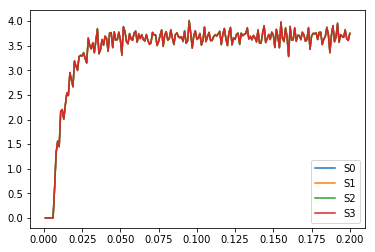

In [16]:
plt.plot(sim.trange(), spa.similarity(sim.data[p_out], stim_vecs))
plt.legend(stim_lbl)

# Decoding directly from oscillator

In [17]:
with nengo.Network() as model:
    in_nd = nengo.Node(gen_feed_func(vocab, stim_lbl, t_present))

    recog = nengo.Ensemble(500, D)

    cleanup = nengo.networks.AssociativeMemory(input_vectors=stim_vecs)
    
    nengo.Connection(in_nd, recog)
    nengo.Connection(recog, cleanup.input)
    nengo.Connection(cleanup.output, recog, transform=-10)
    
    p_in = nengo.Probe(in_nd)
    p_osc = nengo.Probe(recog, synapse=0.01)
    p_filt_spikes = nengo.Probe(recog.neurons, synapse=0.01)

In [18]:
with nengo.Simulator(model) as sim:
    sim.run(t_present*n_items)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


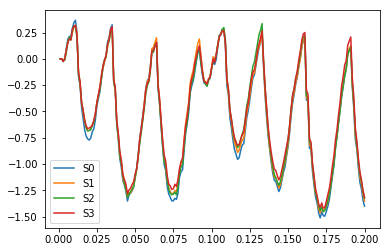

In [19]:
plt.plot(sim.trange(), spa.similarity(sim.data[p_osc], stim_vecs))
plt.legend(stim_lbl)

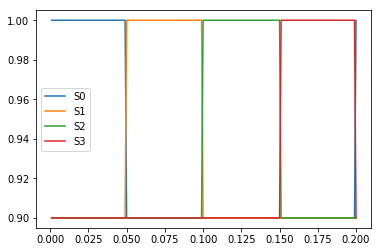

In [20]:
plt.plot(sim.trange(), spa.similarity(sim.data[p_in], stim_vecs))
plt.legend(stim_lbl)

In [21]:
series_len = int(t_present / dt)

repped = []
for targ in targ_class:
    repped.append(np.repeat(targ[None, :], series_len, axis=0))

targ_dat = np.concatenate(repped, axis=0)

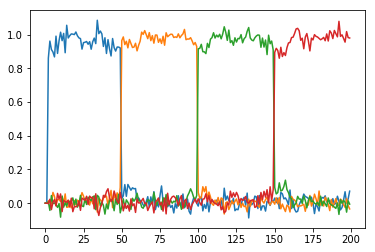

In [22]:
solver = nengo.solvers.LstsqL2(reg=0.02)
decoders, stats = solver(sim.data[p_filt_spikes], targ_dat)
plt.plot(np.dot(sim.data[p_filt_spikes], decoders))

# Decoding from temporal network

Not required due to how effect just decoding from the oscillator is